### Play around with dPCA
Within correct trials, thinking about: 
- what are the axis that best separate early vs. late block positions?
- what are the axis that best separate rule dims?

If plotting trajectories: 
- should less see separation of rule dimension in early block positions compared to late block positions

Run on one session first, then can explore running on multiple sessions via pseudopops

### Imports, setup

In [4]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.pseudo_utils as pseudo_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.behavioral_utils as behavioral_utils
import utils.visualization_utils as visualization_utils
import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
from utils.session_data import SessionData

from models.trainer import Trainer
from models.model_wrapper import ModelWrapper, ModelWrapperLinearRegression
from models.multinomial_logistic_regressor import NormedDropoutMultinomialLogisticRegressor

from trial_splitters.condition_kfold_block_splitter import ConditionKFoldBlockSplitter

import json

from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)

import matplotlib.pyplot as plt
import matplotlib

from dPCA.dPCA import dPCA

In [5]:
PRE_INTERVAL = 1300
POST_INTERVAL = 1500
INTERVAL_SIZE = 10
EVENT = "FeedbackOnset"

sess_name = "20180802"

rule_to_dim = {
    'CIRCLE': 'Shape', 
    'SQUARE': 'Shape', 
    'STAR': 'Shape', 
    'TRIANGLE': 'Shape', 
    'CYAN': 'Color', 
    'GREEN': 'Color', 
    'MAGENTA': 'Color', 
    'YELLOW': 'Color', 
    'ESCHER': 'Pattern', 
    'POLKADOT': 'Pattern', 
    'RIPPLE': 'Pattern', 
    'SWIRL': 'Pattern'
}

In [6]:
sess_name = "20180802"

### Load data, preprocess:
- Smooth firing rates by Gaussian kernel w 50ms std. 
- label trials by early/late block, rule dimension

In [7]:
behavior_path = f"/data/rawdata/sub-SA/sess-{sess_name}/behavior/sub-SA_sess-{sess_name}_object_features.csv"
beh = pd.read_csv(behavior_path)
valid_beh = behavioral_utils.get_valid_trials(beh)
valid_beh = valid_beh.groupby("BlockNumber").filter(lambda x: len(x[x.Response == "Correct"]) > 15)
first_fives = behavioral_utils.get_first_n_corrects_per_block(valid_beh, 5)   
first_fives["Position"] = "First"
last_fives = behavioral_utils.get_last_n_corrects_per_block(valid_beh, 5)
last_fives["Position"] = "Last"
valid_beh = pd.concat([first_fives, last_fives])
valid_beh["RuleDim"] = valid_beh.apply(lambda x: rule_to_dim[x.CurrentRule], axis=1)

In [8]:
frs_path = f"/data/patrick_scratch/multi_sess/{sess_name}/{sess_name}_firing_rates_{PRE_INTERVAL}_{EVENT}_{POST_INTERVAL}_{INTERVAL_SIZE}_bins_10_smooth.pickle"
frs = pd.read_pickle(frs_path)


FileNotFoundError: [Errno 2] No such file or directory: '/data/patrick_scratch/multi_sess/20180802/20180802_firing_rates_1300_FeedbackOnset_1500_10_bins_10_smooth.pickle'

In [5]:
merged = pd.merge(valid_beh, frs, on="TrialNumber", how="inner")

In [6]:
merged = merged[["TrialNumber", "UnitID", "TimeBins", "Position", "RuleDim", "FiringRate"]]

In [7]:
len(merged.TrialNumber.unique())

290

In [8]:
len(valid_beh.TrialNumber.unique())

290

In [9]:
means = merged.groupby(["UnitID", "TimeBins", "Position", "RuleDim"]).mean().reset_index()
means = means.sort_values(["UnitID", "TimeBins", "Position", "RuleDim"])
np_arr = means["FiringRate"].to_numpy()

### Get data in dPCA format, run dPCA

In [10]:
num_units = len(merged.UnitID.unique())
num_timebins = len(merged.TimeBins.unique())
num_positions = 2
num_rule_dims = 3
data = np_arr.reshape((num_units, num_timebins, num_positions, num_rule_dims))

In [25]:
ps = means.Position.unique()

In [26]:
rs = means.RuleDim.unique()

In [14]:
dpca = dPCA(labels='tpr', join={'tp' : ['p','tp'], 'tr': ['r', 'tr'], 'tpr': ['pr', 'tpr']})
dpca.protect = ['t']
res = dpca.fit_transform(data)

In [20]:
res['tr'].shape

(10, 280, 2, 3)

In [49]:
np.sum(dpca.explained_variance_ratio_['tpr'])

0.017818776472656863

### Visualize

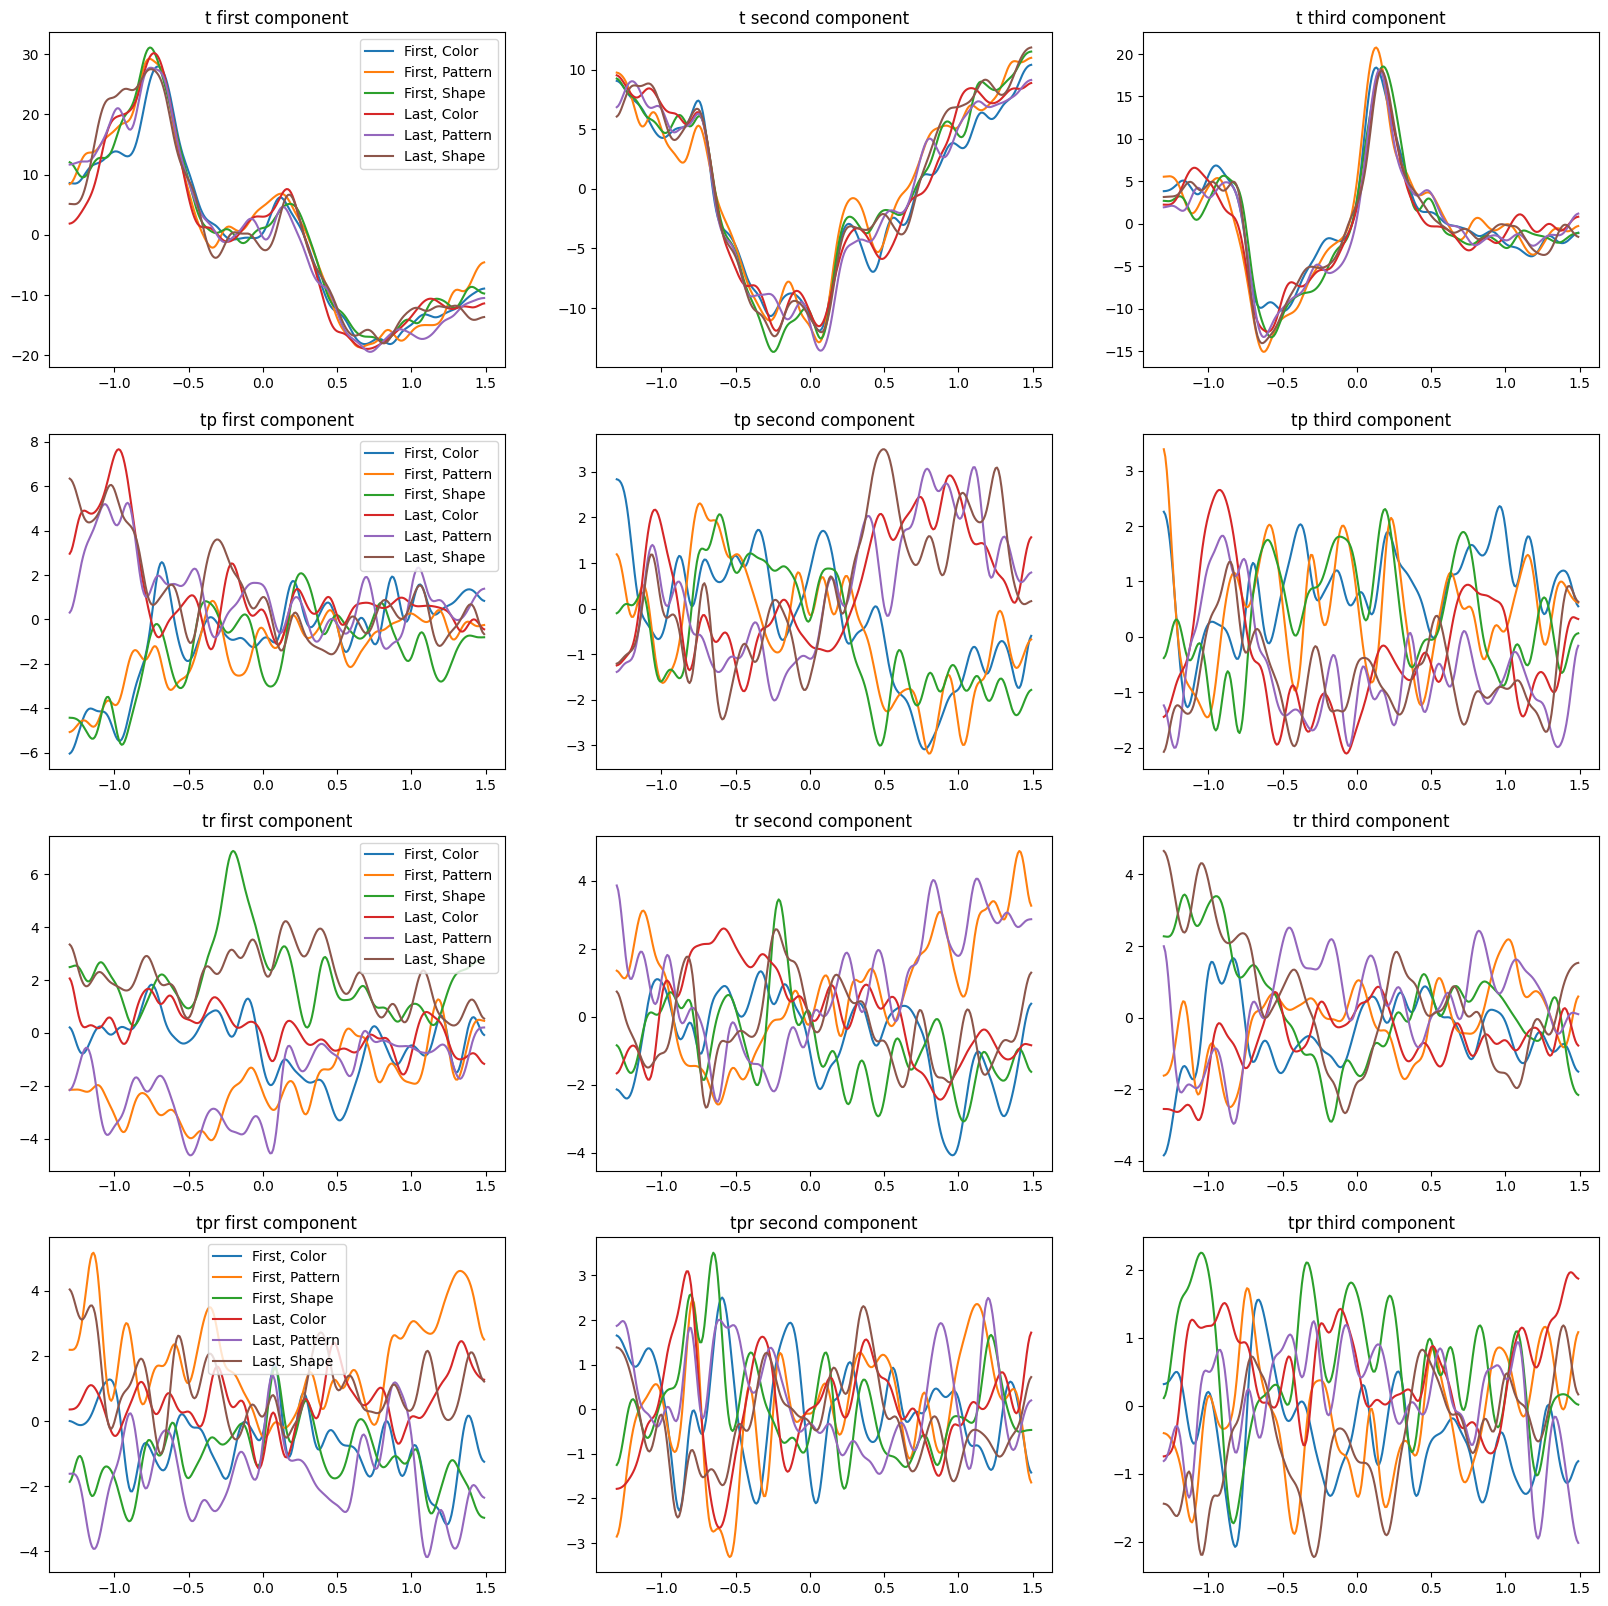

In [40]:

fig, axs = plt.subplots(4, 3, figsize=(20, 20))
x = np.arange(-1.3, 1.5, 0.01)
for comp_idx, comp in enumerate(res):
    mat = res[comp]
    for p_idx in [0, 1]:
        for r_idx in [0, 1, 2]:
            p = ps[p_idx]
            r = rs[r_idx]
            axs[comp_idx, 0].plot(x, mat[0, :, p_idx, r_idx], label=f"{p}, {r}")
            axs[comp_idx, 1].plot(x, mat[1, :, p_idx, r_idx], label=f"{p}, {r}")
            axs[comp_idx, 2].plot(x, mat[2, :, p_idx, r_idx], label=f"{p}, {r}")

            axs[comp_idx, 0].legend()
            axs[comp_idx, 0].set_title(f"{comp} first component")
            axs[comp_idx, 1].set_title(f"{comp} second component")
            axs[comp_idx, 2].set_title(f"{comp} third component")
